# Integrated Modelling for Process Design: Simulation-Informed Design of a Tubular Reactor CE40248: Multiscale Modelling Coursework 2025/2026

## Dataset construction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data-mitrain1.csv', header = None,skiprows=2) # Adjust skiprows to match where your header actually starts

df.columns = ['cln1x', 'Qin', 'T_coolant', 'z', 'c_PO', 'c_PG']

df = df.drop(columns=['cln1x'])


df = df.sort_values(by=['Qin', 'T_coolant', 'z'])


df.head()  # Display the first few rows to verify sorting and grouping

,Qin,T_coolant,z,c_PO,c_PG
1,0.003,277,0.0075,1599.471837,0.528163
6,0.003,277,0.0225,1598.497416,1.502584
11,0.003,277,0.0375,1597.521380,2.478620
16,0.003,277,0.0525,1596.543790,3.456210
21,0.003,277,0.0675,1595.564683,4.435317


In [3]:
counts = df.groupby(['Qin', 'T_coolant']).size()
print("--- Data Count Check ---")
print(counts)

--- Data Count Check ---
Qin    T_coolant
0.003  277          100
0.005  267          100
       277          100
       288          100
0.007  277          100
dtype: int64


In [5]:
num_simulations = df.groupby(['Qin', 'T_coolant']).ngroups
total_points = len(df)
target_var = "PG Concentration (c_PG)"

print("--- DATASET SUMMARY ---")
print(f"Number of Simulations: {num_simulations}")
print(f"Total Data Points:     {total_points}")
print(f"Target Variable:       {target_var}")

--- DATASET SUMMARY ---
Number of Simulations: 5
Total Data Points:     500
Target Variable:       PG Concentration (c_PG)


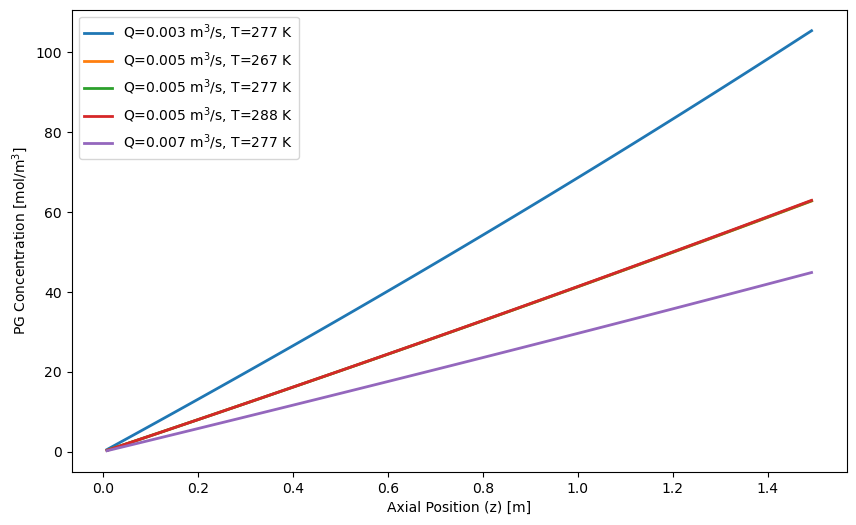

In [6]:

plt.figure(figsize=(10, 6))

# Loop through each case to plot a separate line
for (q, t), group_data in df.groupby(['Qin', 'T_coolant']):
    # Label each line with its specific conditions
    label_text = f"Q={q} m$^3$/s, T={t} K"
    plt.plot(group_data['z'], group_data['c_PG'], label=label_text, linewidth=2)

plt.xlabel('Axial Position (z) [m]')
plt.ylabel('PG Concentration [mol/m$^3$]')
plt.legend()
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Define Features (X) and Target (y)
features = ['Qin', 'T_coolant', 'z']
target = 'c_PG'

X = df[features]
y = df[target]

# Perform random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("\n--- SPLIT SUMMARY ---")
print(f"Training Set Size (80%): {X_train.shape[0]} points")
print(f"Testing Set Size (20%):  {X_test.shape[0]} points")



--- SPLIT SUMMARY ---
Training Set Size (80%): 400 points
Testing Set Size (20%):  100 points


## Standardisation for Neural network

In [5]:

scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Base line data processing

In [ ]:

y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_train.mean())

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_base = r2_score(y_test, y_pred_baseline)

print("--- 3.3 BASELINE DATA PROCESSING ---")
print("Data Split: 80% Train, 20% Test")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples:  {X_test.shape[0]}")
print("\n--- Naive Baseline Performance (Guessing the Mean) ---")
print(f"Baseline MAE:  {mae_base:.4f} mol/m3")
print(f"Baseline RMSE: {rmse_base:.4f} mol/m3")
print(f"Baseline R2:   {r2_base:.4f} (Should be close to 0)")

--- 3.3 BASELINE DATA PROCESSING ---
Data Split: 80% Train, 20% Test
Training Samples: 400
Testing Samples:  100

--- Naive Baseline Performance (Guessing the Mean) ---
Baseline MAE:  20.6953 mol/m3
Baseline RMSE: 25.6355 mol/m3
Baseline R2:   -0.0415 (Should be close to 0)


## Random Forest Regressor

--- 1. HYPERPARAMETER TUNING (Grid Search) ---
Best Parameters Found: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}

--- 2. MODEL EVALUATION (Test Set) ---
Random Forest MAE:  0.5641 mol/m3
Random Forest RMSE: 0.7496 mol/m3
Random Forest R2:   0.9991 (Goal: > 0.95)

--- 3. PHYSICAL INTERPRETABILITY (Feature Importance) ---


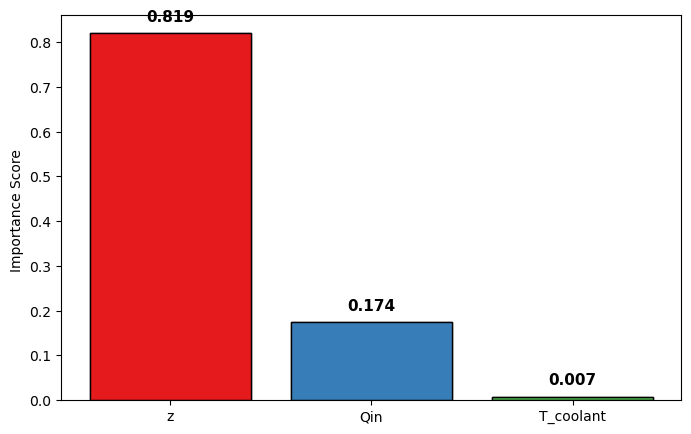


--- TIMING METRICS (Random Forest) ---
Training Time:      0.5615 seconds
Prediction Time:    0.0175 seconds (for 100 samples)


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


print("--- 1. HYPERPARAMETER TUNING (Grid Search) ---")

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 500, 800],      # Number of trees
    'max_depth': [None, 10, 20],         # Max depth of each tree
    'max_features': ['sqrt', 0.3, 0.5],   # Number of features to consider at each split/ add point for handling correlation 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],        # Controls smoothing/overfitting
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)


best_rf = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")


print("\n--- 2. MODEL EVALUATION (Test Set) ---")

y_pred_rf = best_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE:  {mae_rf:.4f} mol/m3")
print(f"Random Forest RMSE: {rmse_rf:.4f} mol/m3")
print(f"Random Forest R2:   {r2_rf:.4f} (Goal: > 0.95)")


print("\n--- 3. PHYSICAL INTERPRETABILITY (Feature Importance) ---")

importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1] # Sort biggest to smallest


plt.figure(figsize=(8, 5))
# 'viridis', 'plasma', 'Spectral', or 'husl' are great choices
colors = sns.color_palette("Set1", len(indices))

# Create Bars
if hasattr(best_rf, "estimators_"): 
    std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
else:
    std = np.zeros(len(importances))
bars = plt.bar(range(X.shape[1]), importances[indices],
            color=colors, align="center", 
            edgecolor='black', alpha=0.9)

plt.bar(range(X.shape[1]), importances[indices], align="center", color=colors, edgecolor='black')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.ylabel("Importance Score ")
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
        height + 0.02,                      # Y-coordinate: Slightly above the bar (adjust 0.02 if needed)
        f'{height:.3f}',                    # The Text: Formatted to 3 decimal places
        ha='center', va='bottom',           # Alignment: Center horizontally, sit on bottom
        fontsize=11, fontweight='bold', color='black'
    )
plt.show()

import time

print("\n--- TIMING METRICS (Random Forest) ---")

# 1. Measure Training Time
start = time.time()
best_rf.fit(X_train, y_train) 
end = time.time()
rf_train_time = end - start

# 2. Measure Prediction Time (Latency)
start = time.time()
_ = best_rf.predict(X_test)
end = time.time()
rf_pred_time = end - start

print(f"Training Time:      {rf_train_time:.4f} seconds")
print(f"Prediction Time:    {rf_pred_time:.4f} seconds (for {len(X_test)} samples)")

In [10]:
# compare with baseline 
improvement = (mae_base - mae_rf) / mae_base * 100 # from the base line
print(f"Improvement over Baseline: {improvement:.1f}%")

print(grid_search.best_params_)

Improvement over Baseline: 97.3%
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


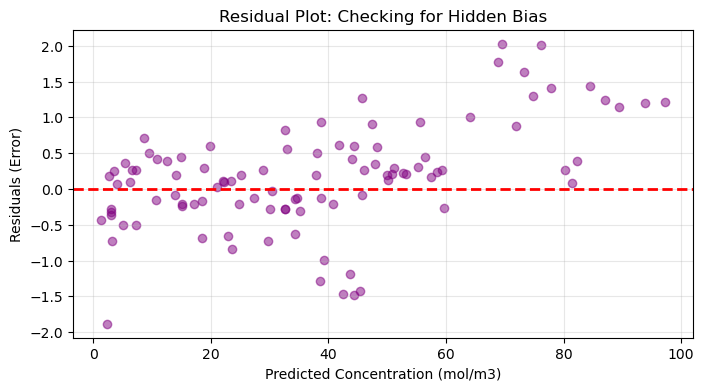

In [12]:
# Calculate Residuals (Errors)
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 4))
plt.scatter(y_pred_rf, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2) # The "Zero Error" line
plt.xlabel("Predicted Concentration (mol/m3)")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot: Checking for Hidden Bias")
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
print("\n--- 5. CRITICAL ANALYSIS: Is 'z' doing all the work? ---")
# Train a simple model using ONLY 'z'
X_train_simple = X_train[['z']]
X_test_simple = X_test[['z']]

rf_simple = RandomForestRegressor(n_estimators=100, random_state=42)
rf_simple.fit(X_train_simple, y_train)
y_pred_simple = rf_simple.predict(X_test_simple)

r2_simple = r2_score(y_test, y_pred_simple)
print(f"R2 with ALL features: {r2_rf:.4f}")
print(f"R2 with ONLY 'z':     {r2_simple:.4f}")
print(f"Contribution of other features: {r2_rf - r2_simple:.4f}")


--- 5. CRITICAL ANALYSIS: Is 'z' doing all the work? ---
R2 with ALL features: 0.9991
R2 with ONLY 'z':     0.5263
Contribution of other features: 0.4728



--- 4. VISUALIZATION ---


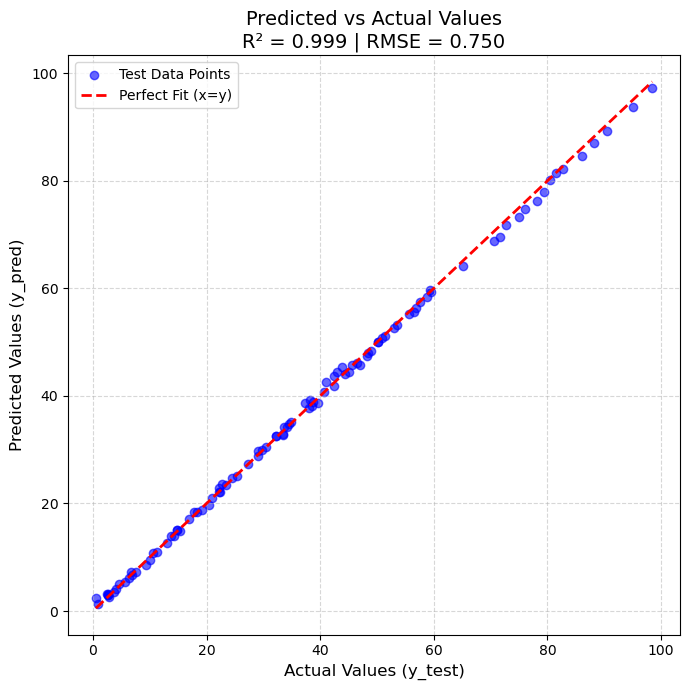

In [14]:
print("\n--- 4. VISUALIZATION ---")

plt.figure(figsize=(7, 7))

# Alpha=0.6 makes points semi-transparent so you can see where they pile up
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.6, label='Test Data Points')


# We calculate the min and max to draw a diagonal line from corner to corner
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit (x=y)')


plt.title(f"Predicted vs Actual Values\nR² = {r2_rf:.3f} | RMSE = {rmse_rf:.3f}", fontsize=14)
plt.xlabel("Actual Values (y_test)", fontsize=12)
plt.ylabel("Predicted Values (y_pred)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Feed Forward Neural network

--- 1. HYPERPARAMETER TUNING (Grid Search) ---
Running Grid Search... (This might take a minute)


Best NN Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}

Neural Network MAE:  0.8458
Neural Network RMSE: 1.0748
Neural Network R2:   0.9982


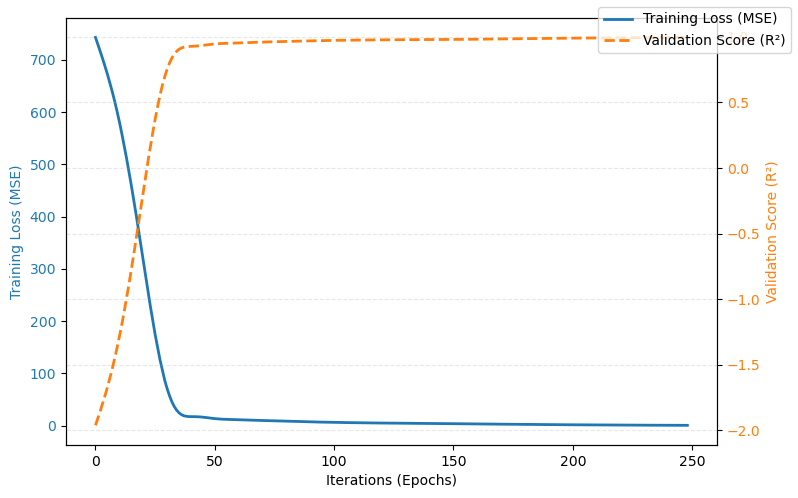


--- OVERFITTING ANALYSIS ---
Look at the graph:
1. BLUE Line should go DOWN (Error decreasing).
2. ORANGE Line should go UP (Accuracy increasing).
3. OVERFITTING SIGN: If Blue keeps dropping but Orange flattens or drops.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


print("--- 1. HYPERPARAMETER TUNING (Grid Search) ---")

# 1. Define the Neural Network
# early_stopping=True is CRITICAL. It sets aside 10% of training data as "Validation" 
# to calculate the score at every epoch.
mlp = MLPRegressor(
    activation='relu', 
    solver='adam', 
    max_iter=2000, 
    early_stopping=True,      # Required to get validation curves
    validation_fraction=0.1,  # 10% of data used for validation
    random_state=42
)

# 2. Define the Grid
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]  # L2 Regularization (Higher alpha = less overfitting)
}

# 3. Run Grid Search
print("Running Grid Search... (This might take a minute)")
grid_search_nn = GridSearchCV(
    estimator=mlp, 
    param_grid=param_grid_nn, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search_nn.fit(X_train_scaled, y_train)

best_nn = grid_search_nn.best_estimator_
print(f"Best NN Parameters: {grid_search_nn.best_params_}")

# --- 2. EVALUATION ---
y_pred_nn = best_nn.predict(X_test_scaled)

mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\nNeural Network MAE:  {mae_nn:.4f}")
print(f"Neural Network RMSE: {rmse_nn:.4f}")
print(f"Neural Network R2:   {r2_nn:.4f}")

# --- 3. PLOTTING (Dual Axis for Sklearn) ---
# Since Sklearn saves 'Loss' (MSE) for training but 'Score' (R2) for validation,
# we need two y-axes to compare them properly.

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Training Loss (Left Axis - Blue)
line1, = ax1.plot(best_nn.loss_curve_, label='Training Loss (MSE)', color='tab:blue', linewidth=2)
ax1.set_xlabel('Iterations (Epochs)')
ax1.set_ylabel('Training Loss (MSE)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Validation Score (Right Axis - Orange)
ax2 = ax1.twinx()
line2, = ax2.plot(best_nn.validation_scores_, label='Validation Score (R²)', color='tab:orange', linestyle='--', linewidth=2)
ax2.set_ylabel('Validation Score (R²)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print("\n--- OVERFITTING ANALYSIS ---")
print("Look at the graph:")
print("1. BLUE Line should go DOWN (Error decreasing).")
print("2. ORANGE Line should go UP (Accuracy increasing).")
print("3. OVERFITTING SIGN: If Blue keeps dropping but Orange flattens or drops.")

In [7]:
import time

print("\n--- TIMING METRICS (MLP Regressor - Sklearn) ---")

# 1. Measure Training Time
# We re-train it once to see how fast it is 'from scratch'
start = time.time()
best_nn.fit(X_train_scaled, y_train) 
end = time.time()
mlp_train_time = end - start

# 2. Measure Prediction Time (Latency)
start = time.time()
_ = best_nn.predict(X_test_scaled)
end = time.time()
mlp_pred_time = end - start

print(f"Training Time:      {mlp_train_time:.4f} seconds")
print(f"Prediction Time:    {mlp_pred_time:.4f} seconds (for {len(X_test)} samples)")


--- TIMING METRICS (MLP Regressor - Sklearn) ---
Training Time:      0.2399 seconds
Prediction Time:    0.0001 seconds (for 100 samples)


## Tensorflow

--- RESTARTING TENSORFLOW TRAINING (SAFE MODE) ---
Tuning Neural Network... (This should take < 1 minute)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=0.01, model__neurons=50; total time=  23.5s
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=0.01, model__neurons=50; total time=  24.0s
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=0.01, model__neurons=50; total time=  24.3s
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=0.01, model__neurons=100; total time=  25.3s
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=0.01, model__neurons=100; total time=  24.2s
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=0.01, model__neurons=100; total time=  24.1s
[CV] END batch_size=32, epochs=500, model__hidden_layers=1, model__learning_rate=

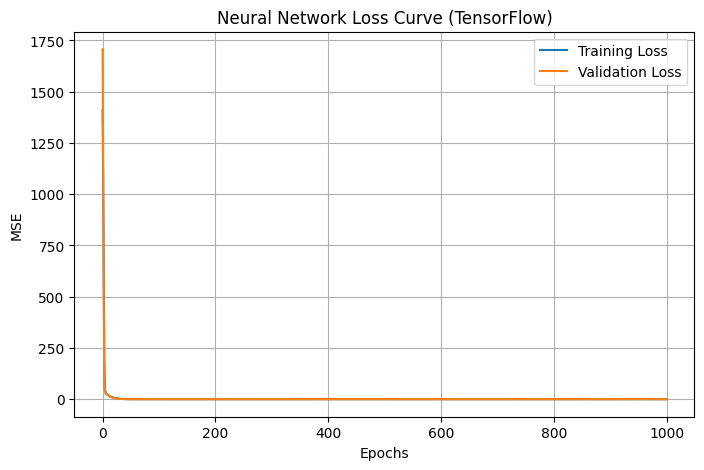

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

print("--- RESTARTING TENSORFLOW TRAINING (SAFE MODE) ---")

# Define a function to create the model (Required for GridSearch)
def create_model(hidden_layers=1, neurons=50, learning_rate=0.01):
    model = Sequential()
    
    # Input Layer
    model.add(tf.keras.Input(shape=(X_train_scaled.shape[1],)))
    
    # Hidden Layers (Tunable)
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu')) # ReLU 
        
    # Output Layer (Linear)
    model.add(Dense(1, activation='linear')) # Linear output
    
    # Compile with Adam and MSE
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 2. Wrap it for Scikit-Learn
# verbose=0 shuts up the training logs until we want them
model = KerasRegressor(model=create_model, verbose=0)

# 3. Define Hyperparameters to Tune (Grid Search)
param_grid = {
    'model__hidden_layers': [1, 2],       # Try 1 or 2 hidden layers
    'model__neurons': [50, 100],          # Try 50 or 100 neurons
    'model__learning_rate': [0.01, 0.001], # Try different learning rates
    'epochs': [500],                      # Fixed epochs for tuning
    'batch_size': [32]
}


print("Tuning Neural Network... (This should take < 1 minute)")
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=3, scoring='neg_mean_squared_error',
                    verbose=2)

grid_result = grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_result.best_params_}")


print("\nRetraining best model to get Loss Curve...")
best_params = grid_result.best_params_

# Re-build the best model manually to get the history/loss curve
final_model = create_model(
    hidden_layers=best_params['model__hidden_layers'],
    neurons=best_params['model__neurons'],
    learning_rate=best_params['model__learning_rate']
)

# Fit and save history
history = final_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=1000, 
    batch_size=32, 
    verbose=0
)

y_pred_nn = final_model.predict(X_test_scaled)

mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\nTensorFlow NN MAE:  {mae_nn:.4f}")
print(f"TensorFlow NN RMSE: {rmse_nn:.4f}")
print(f"TensorFlow NN R2:   {r2_nn:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss Curve (TensorFlow)')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

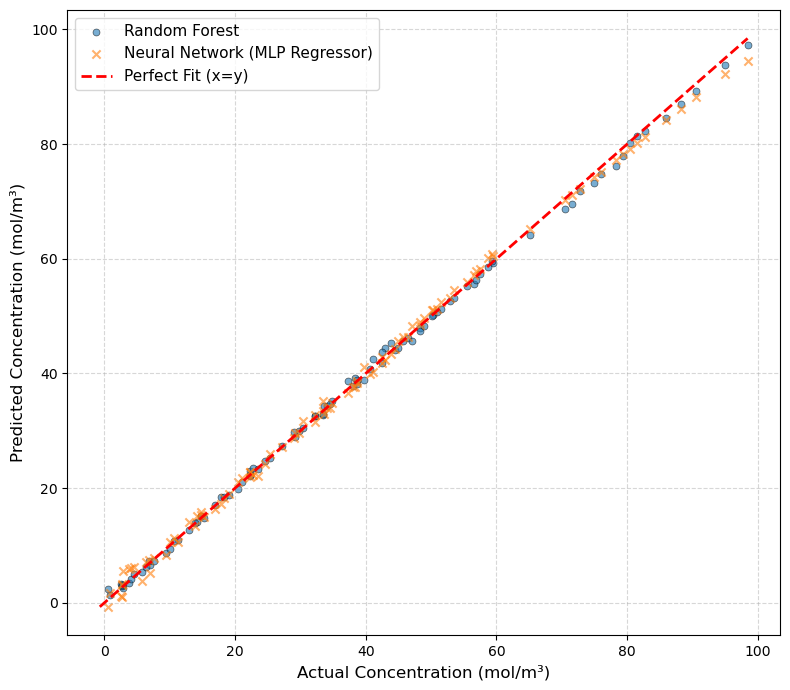

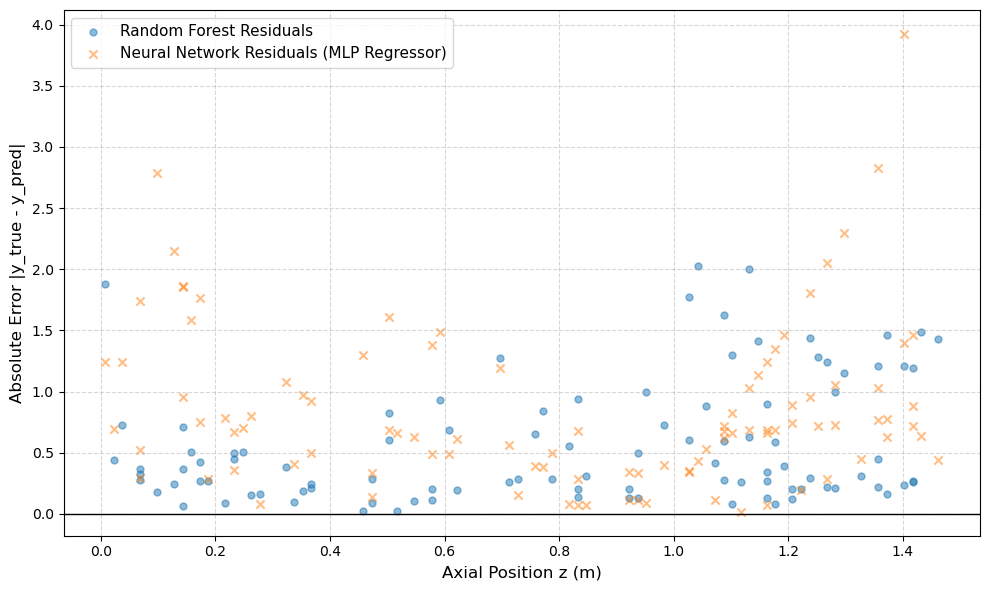

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# VISUALISATION 1: PARITY PLOT (Predicted vs Actual)
# ==========================================

plt.figure(figsize=(8, 7)) # Adjust size as needed

# 1. Scatter Random Forest (Blue Circles)
plt.scatter(y_test, y_pred_rf, color='tab:blue', alpha=0.6, label='Random Forest', s=25, edgecolor='k', linewidth=0.5)

# 2. Scatter Neural Network (Orange Crosses)
plt.scatter(y_test, y_pred_nn, color='tab:orange', alpha=0.6, label='Neural Network (MLP Regressor)', marker='x', s=35)

# 3. The Perfect Fit Line
min_val = min(y_test.min(), y_pred_rf.min(), y_pred_nn.min())
max_val = max(y_test.max(), y_pred_rf.max(), y_pred_nn.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (x=y)')

# 4. Styling
plt.xlabel('Actual Concentration (mol/m³)', fontsize=12)
plt.ylabel('Predicted Concentration (mol/m³)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ==========================================
# VISUALISATION 2: RESIDUAL PLOT (Error vs Position)
# ==========================================

# Setup Data
# Ensure we are grabbing the 'z' column correctly. 
# If X_test is a DataFrame:
z_test_values = X_test['z']
# If X_test is a numpy array (and z is column 0), use: z_test_values = X_test[:, 0]

abs_err_rf = np.abs(y_test - y_pred_rf)
abs_err_nn = np.abs(y_test - y_pred_nn)

plt.figure(figsize=(10, 6)) # Wider figure for the position plot

# 1. Scatter RF Error
plt.scatter(z_test_values, abs_err_rf, color='tab:blue', alpha=0.5, label='Random Forest Residuals', s=25)

# 2. Scatter NN Error
plt.scatter(z_test_values, abs_err_nn, color='tab:orange', alpha=0.5, label='Neural Network Residuals (MLP Regressor)', marker='x', s=35)

# 3. Styling
plt.xlabel('Axial Position z (m)', fontsize=12)
plt.ylabel('Absolute Error |y_true - y_pred|', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

# Optional: Add a "Zero Error" line just to anchor the eye
plt.axhline(0, color='black', linewidth=1, linestyle='-')

plt.tight_layout()
plt.show()

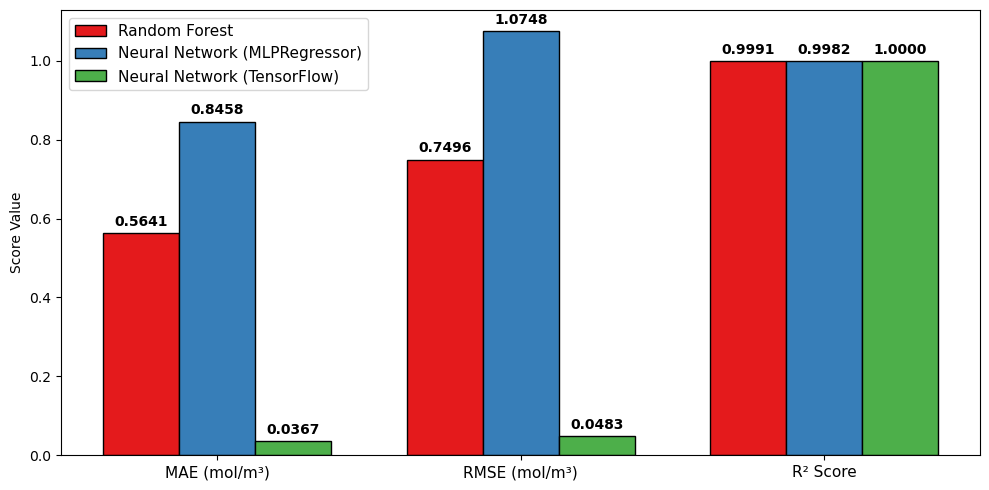

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# SECTION 5: FINAL MODEL COMPARISON
# ==========================================


# 1. Prepare the Data
# (Ensure these variables exist from your previous sections)
metrics = ['MAE (mol/m³)', 'RMSE (mol/m³)', 'R² Score']

# Collect your values (e.g., 0.5641, 0.7496, 0.9991)
# Note: R2 is unitless, others are mol/m3, but since they are all ~0.5 to 1.0, 
# they fit well on the same graph.
rf_values = [mae_rf, rmse_rf, r2_rf]
nn_values = [mae_nn, rmse_nn, r2_nn]  # Replace with actual variables if named differently
nnT_values = [0.0367, 0.0483, 1.0000]

x = np.arange(len(metrics))  # Label locations
width = 0.25                 # Width of the bars

# Use Seaborn Set1 palette
colors = sns.color_palette("Set1", 3)

# 2. Create the Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Assign colors from the palette
rects1 = ax.bar(x - width, rf_values, width, label='Random Forest', color=colors[0], edgecolor='black')
rects2 = ax.bar(x, nn_values, width, label='Neural Network (MLPRegressor)', color=colors[1], edgecolor='black')
rects3 = ax.bar(x + width, nnT_values, width, label='Neural Network (TensorFlow)', color=colors[2], edgecolor='black')

# 3. Styling
ax.set_ylabel('Score Value')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='upper left', fontsize=11)

# 4. Add Text Labels on Top of Bars (The "Professional Touch")
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()